# Policy analysis
The point of this notebook is to analyze the privacy policies fetched with the spider.  
This presumes all the policies that are marked as successfully gathered in the report file are good, and only looks at said policies

In [13]:
import csv
import os
import json
import math

import justext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import langid
from readability import Readability
import textstat
    
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.cluster import DBSCAN

In [14]:
def site_name_from_file_name(file_name):
    return file_name[len("policy_"):len(file_name) - 4]

In [15]:
def make_policy_files():
    policy_files = []
    for filename in policy_file_names:
        policy_files.append(open(DATADIR + filename))
    return policy_files

## 1 Overview

In [16]:
DATADIR = "data/"
POLICY_FILE_PREFIX = "policy_"
REPORT_FILE_NAME = "crawl_report.json"

In [17]:
report_json = pd.read_json(DATADIR + REPORT_FILE_NAME)
report_json

,url,policy_domain,policy_url,policy_file,uses_iubenda,success,ignore
0,https://www.wikipedia.org/,meta.wikimedia.org,https://meta.wikimedia.org/wiki/Privacy_policy,policy_www.wikipedia.org.txt,False,True,False
1,https://www.google.com/,www.google.com,https://www.google.com/intl/it/policies/privacy/,policy_www.google.com.txt,False,True,False
2,https://www.corriere.it/,www.corriere.it,https://www.corriere.it/privacy.shtml,policy_www.corriere.it.txt,False,True,False
3,https://www.gazzetta.it/,www.gazzetta.it,https://www.gazzetta.it/privacy.shtml,policy_www.gazzetta.it.txt,False,True,False
4,https://twitter.com,twitter.com,https://twitter.com/privacy,policy_twitter.com.txt,False,True,False
...,...,...,...,...,...,...,...
561,https://www.afor.mi.it/,www.afor.mi.it,http://www.afor.mi.it/privacy,policy_www.afor.mi.it.txt,False,True,False
562,https://www.pages.mi.it/,None,None,policy_www.pages.mi.it.txt,False,False,False
563,https://comune.vizzolopredabissi.mi.it/,comune.vizzolopredabissi.mi.it,https://comune.vizzolopredabissi.mi.it/informa...,policy_comune.vizzolopredabissi.mi.it.txt,False,True,False
564,https://comune.vanzaghello.mi.it/,comune.vanzaghello.mi.it,https://comune.vanzaghello.mi.it/cookie-policy,policy_comune.vanzaghello.mi.it.txt,False,True,False


### 1.1 Success rate

In [18]:
# Recap
number_total = len(report_json)
print("Analyzed sites: " + str(number_total))

successful = report_json.loc[report_json["success"] == True]

# bl = []
# for l in report_json["policy_file"]:
#     try:
#         bl.append(len(open(DATADIR + l).read()) > 0)
#     except:
#         bl.append(False)

# s = pd.Series(bl)

# # successful = report_json.loc[(len(open(report_json["policy_file"]).read()) > 0)]
# successful = report_json[s.values]

number_successful = len(successful)
print("Successfully downloaded: " + str(number_successful))

print("Success rate: " + str(round((100 * number_successful / number_total), 1)) + "%")

failed_with_url = report_json.loc[pd.notna(report_json["policy_url"])
                                  & (report_json["success"] == False)]
print("Policy url found but no good policy found: " + str(len(failed_with_url)))
failed_with_url

Analyzed sites: 566
Successfully downloaded: 460
Success rate: 81.3%
Policy url found but no good policy found: 47


,url,policy_domain,policy_url,policy_file,uses_iubenda,success,ignore
11,https://mediasetinfinity.mediaset.it/,mediasetinfinity.mediaset.it,https://mediasetinfinity.mediaset.it/info/privacy,policy_mediasetinfinity.mediaset.it.txt,False,False,False
21,https://www.mygpteam.com/,www.mygpteam.com,https://www.mygpteam.com/privacy.php,policy_www.mygpteam.com.txt,False,False,False
26,https://www.lastampa.it/,www.lastampa.it,https://www.lastampa.it/rubriche/sentimenti-e-...,policy_www.lastampa.it.txt,True,False,False
27,https://www.sky.it/,www.sky.it,https://www.sky.it/info/moduli-contrattuali/pr...,policy_www.sky.it.txt,False,False,False
61,https://consent.yahoo.com/v2/collectConsent?se...,consent.yahoo.com,https://consent.yahoo.com/redirect?to=https%3A...,policy_consent.yahoo.com.txt,False,False,False
67,https://www.aranzulla.it:443/,www.iubenda.com,https://www.iubenda.com/privacy-policy/281842,policy_www.aranzulla.it:443.txt,True,False,False
75,https://freenem.com,freenem.com,https://freenem.com/gdpr,policy_freenem.com.txt,False,False,False
79,https://www.iliad.it/,www.iliad.it,https://www.iliad.it/docs/informativa_privacy/...,policy_www.iliad.it.txt,False,False,False
81,https://www.paypal.com/it/home,www.paypal.com,https://www.paypal.com/privacy-center,policy_www.paypal.com.txt,False,False,False
105,https://www.leggo.it/,www.leggo.it,https://www.leggo.it/javascript:acceptAllCooki...,policy_www.leggo.it.txt,True,False,False


### 1.2 Sites overview

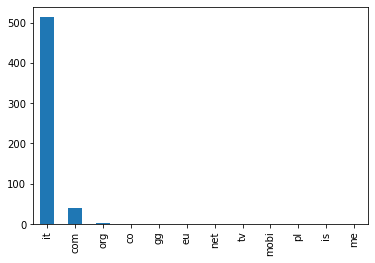

In [19]:
# TLDs

urls = report_json["url"]
ul = urls.tolist()

tlds = {}
for url in ul:
    slfssplit = (url.split("/")[2]).split(".")
    tld = slfssplit[len(slfssplit) - 1].split(":")[0]
#     tld = ((url.split(".")[len(url.split(".")) - 1]).split("/")[0]).split(":")[0]
    if tld in tlds.keys():
        tlds[tld] = tlds[tld] + 1
    else:
        tlds[tld] = 1
        
pd.Series(tlds).sort_values(ascending = False).plot.bar()
plt.show()

## 2 Simple analysis

In [20]:
# Open policy files
policy_file_names = successful["policy_file"].tolist()

### 2.1 Language detection

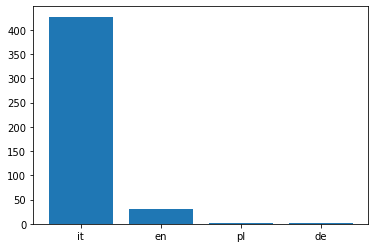

In [21]:
# Language detection
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))


languages = {}
for file in policy_files:
    languages[file.name] = langid.classify(file.read())[0]

plt.bar(pd.Series(languages).value_counts().keys(), pd.Series(languages).value_counts())
plt.show()

### 2.2 Detecting suspicious entries with DBSCAN
Some bad text will make it through the spider. With some clustering we can find suspicious texts and weed them out manually.  
Language detection is done before this in order to do clustering separately for each detected language.  
This step also detects policies from the same company on different sites i.e. wikimedia.org and wikipedia.org quite well.


Current language: en
Found 3 clusters
Labels: 
[-1 -1  0  0 -1  0  0 -1  0  0 -1 -1  0 -1  0 -1  0 -1 -1  0 -1 -1  0 -1
 -1  1  1  1  1 -1]

Cluster: -1 with 15 elements
data/policy_www.wikipedia.org.txt     Privacy policy From Meta, a Wikimedia project ...
data/policy_twitter.com.txt           Skip to main content Privacy Policy Twitter Pr...
data/policy_asura.gg.txt              Asura Scans Home Bookmarks Comics Recruitment ...
data/policy_airporthandling.eu.txt    b'COOKIE POLICY\n\nRev. October 2022\n\nAirpor...
data/policy_chaturbate.com.txt        THE ACT OF MASTURBATING WHILE CHATTING ONLINE ...
data/policy_www.whatsapp.com.txt      Select your language čeština Deutsch English e...
data/policy_famiboards.com.txt        Forums TreehouseThe RoostPokémon CenterWarp Zo...
data/policy_www.netsdaily.com.txt     Skip to main content Cookie banner We use cook...
data/policy_toonily.com.txt           Home Manhwa Search New Trending Completed Mang...
data/policy_www.dailyfx.com.txt      

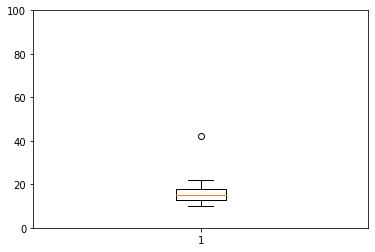


Cluster: 0 with 11 elements
data/policy_search-hub.co.txt         MENU Home OEMs/Carriers Developers Technology ...
data/policy_www.fandom.com.txt        FANDOM Fan Central Beta Games Anime Movies TV ...
data/policy_www.reddit.com.txt        Advertisement Reddit and its partners use cook...
data/policy_www.libero.it.txt         Privacy & Terms Sign in Overview Privacy Polic...
data/policy_bitly.com.txt             Skip Navigation Why Bitly? Bitly 101An introdu...
data/policy_www.booking.com.txt       Skip to main content Select your language Sugg...
data/policy_outlook.live.com.txt      Skip to main content Microsoft Privacy Privacy...
data/policy_silverprice.org.txt       Skip to main content Main Menu SPX Charts Silv...
data/policy_telegram.org.txt          English Bahasa Indonesia Bahasa Melayu Deutsch...
data/policy_www.scoop.it.txt          Research and publish the best content. Get Sta...
data/policy_www.cybrary.it:443.txt    Training Library Start Your Career Certificati...
Nam

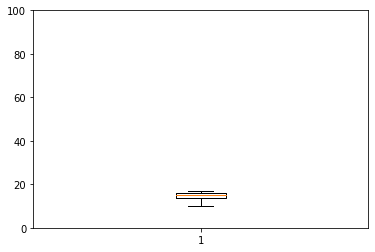


Cluster: 1 with 4 elements
data/policy_www.eni.com.txt                    Contatti Documentazione Prodotti e Servizi ENI...
data/policy_www.sissa.it.txt                   Skip to contentSkip to navigation English Ital...
data/policy_artbonus.gov.it.txt                This website uses cookies We use cookies to pe...
data/policy_integrazionemigranti.gov.it.txt    × Home\nNews\nApprofondimenti\nEventi\nNormati...
Name: Text, dtype: object

Higher score is harder to read.
Hard to read texts: 1
as a percentage of total: 25.0%
Average grade level: 16.8
Texts above recommended level (8th grade) 100.0%


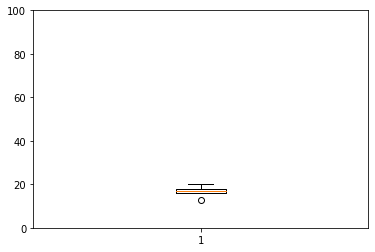


Current language: it
Found 6 clusters
Labels: 
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  3  0  0
  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
  0  0  0  0  0  0  0  2  0  0  0  0  2  0  0  2  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  3  0  1  0  0  0  0  0  0
  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  3  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  3  3
  0  0  0 -1  0  0  3  0  0  0  0  0  0  0  0  0  0  0  2  0  0  3  0  0
  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  3  0  0  3
  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  3  0  0  0
  0

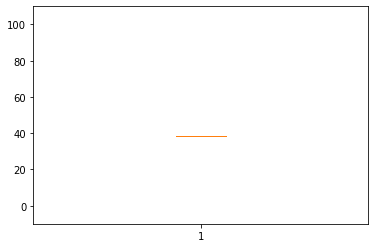


Cluster: 0 with 392 elements
data/policy_www.google.com.txt                    Privacy e termini Privacy e termini Accedi Int...
data/policy_www.corriere.it.txt                   desktop includes2013/SSI/notification/global.j...
data/policy_www.gazzetta.it.txt                   desktop //js2.gazzettaobjects.it//notifiche/gl...
data/policy_www.youtube.com.txt                   Privacy e termini Accedi Introduzione Norme su...
data/policy_www.repubblica.it.txt                 Abbonati Abbonati AbbonatiGedi Smile Menu di n...
                                                                        ...                        
data/policy_www.comune.settala.mi.it.txt          Passa al contenuto principale Passa alla barra...
data/policy_www.afor.mi.it.txt                    Chi siamo Accreditamenti I nostri corsi Gestio...
data/policy_comune.vizzolopredabissi.mi.it.txt    Amministrazione Sindaco Consiglio Comunale Giu...
data/policy_comune.vanzaghello.mi.it.txt          Questo sito utilizza

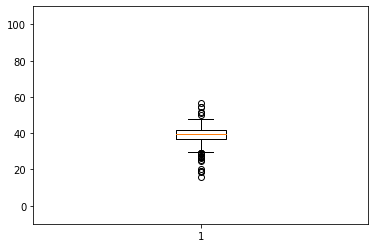


Cluster: 1 with 2 elements
data/policy_www.moto.it.txt        News Prove Elettrico MotoGP SBK Sport Viaggi V...
data/policy_www.automoto.it.txt    News Prove Elettrico F1 Saloni Listino Nuovo L...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%


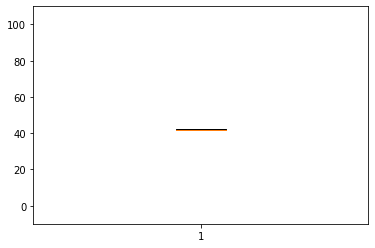


Cluster: 2 with 12 elements
data/policy_www.italotreno.it.txt         b"INFORMATIVA AGLI INTERESSATI AI SENSI DELL\x...
data/policy_www.laleggepertutti.it.txt    b"INFORMATIVA PRIVACY\nGENERAL DATA PROTECTION...
data/policy_business.aruba.it.txt         b"Informativa Privacy\nARUBA BUSINESS\n\nInfor...
data/policy_www.libraccio.it.txt          b'INFORMATIVA SUL TRATTAMENTO DEI DATI PERSONA...
data/policy_www.intervieweb.it:443.txt    b'INFORMATIVA\nsul trattamento dei dati person...
data/policy_www.acea.it.txt               b'NOTA INFORMATIVA\nSULLE CONDIZIONI DI UTILIZ...
data/policy_www.finanze.it.txt            b"INFORMATIVA SUL TRATTAMENTO\n\xe2\x80\x9chtt...
data/policy_www.neosair.it.txt            b'Informativa al trattamento dei dati ex art. ...
data/policy_www.nicolaporro.it.txt        b"Lunifin Srl\nLargo F. Richini 2\\A\n20122 Mi...
data/policy_www.unicusano.it.txt          b"INFORMATIVA WEB PRIVACY AI SENSI DELL\xe2\x8...
data/policy_www.finanze.gov.it.txt        b"INFORMA

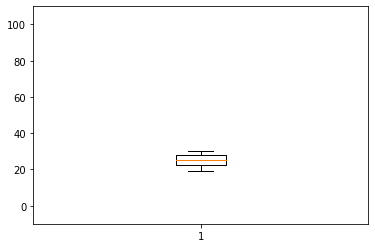


Cluster: 3 with 18 elements
data/policy_www.today.it.txt           Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.romatoday.it.txt       Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.milanotoday.it.txt     Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.napolitoday.it.txt     Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.palermotoday.it.txt    Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.padovaoggi.it.txt      Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.bolognatoday.it.txt    Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.bresciatoday.it.txt    Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.lecceprima.it.txt      Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.foggiatoday.it.txt     Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.torinotoday.it.txt     Informativa Privacy e Cookie Policy Siti W

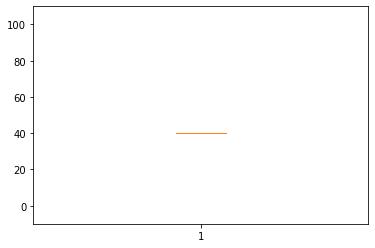


Cluster: 4 with 2 elements
data/policy_www.robadadonne.it.txt    Stai leggendo:Educazione sessuale è educazione...
data/policy_www.minori.gov.it.txt     Salta al contenuto principaleRaggiungi il piè ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 35.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%


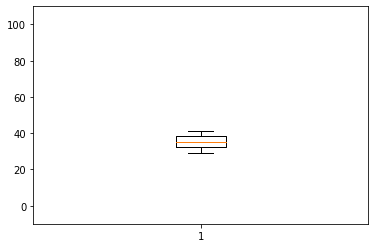


Current language: pl
Sample size for  too small

Current language: de
Sample size for  too small


In [22]:
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

langs = pd.Series(languages).unique()

for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
#     else:
#         break
        
    print("\nCurrent language: " + lang)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
    )


    texts_in_lang = []
    
    df_texts_in_lang = pd.DataFrame(columns = ["Text"])

    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
            texts_in_lang.append(file_text)
            df_texts_in_lang.loc[file.name] = file_text
            
    if len(texts_in_lang) < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue

    # --

    X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    
    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))

    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()

    X = X_lsa

    # eps=1.30 works well
    # 1.20 is where it starts to make to many clusters with just one element
    # 1.25 with min_samples=2 has a reasonable amount of outliers
    
    custom_eps = 1.15
    
#     db = DBSCAN(eps=custom_eps, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
#     db = DBSCAN(eps=custom_eps, min_samples=1).fit(X)
    db = DBSCAN(eps=custom_eps, min_samples=2).fit(X) # Avoid singletons

    print("Found " +  str(len(np.unique(db.labels_))) + " clusters")
    print("Labels: \n" + str(db.labels_))
    
    db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                                 "Text" : df_texts_in_lang.Text},
    #                              "Filename" : df_texts_in_lang.index},
                         index = df_texts_in_lang.index)
    db_df

    dissimilar_entries_urls = db_df.loc[db_df["Cluster"] != 0].index.tolist()
#     print(dissimilar_entries_urls) # Dissimilar entries
#     print(db_df.loc[db_df["Cluster"] == 0])

    # Print out each cluster
    for cluster in np.unique(db.labels_):
        cluster_content = db_df.loc[db_df["Cluster"] == cluster]["Text"]
        cluster_size = len(cluster_content)
        
        print("\nCluster: " + str(cluster) + " with " + str(cluster_size) + " elements")
        print(cluster_content)
        
        ## Make wordclouds for each cluster?
#         all_policy_text = ""
#         for policy_text in cluster_content:
#             all_policy_text += policy_text

#         wordcloud = WordCloud().generate(all_policy_text)

#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis("off")
#         plt.show()
        
        ## Readability analysis
        ar_readability_scores = []
        
        if lang == "en": ## Readability is only available in English and Italian
            # Set box plot scale
            plt.ylim(0, 100)
            
            hard_to_read = 0
            above_8th_grade = 0
            avg_grade_level = 0.0
            for policy_text in cluster_content:
                r = Readability(policy_text)
                fk = r.flesch_kincaid()
                grade_level = fk.grade_level

                avg_grade_level = avg_grade_level + float(grade_level)

                if int(grade_level) > 8:
                    above_8th_grade = above_8th_grade + 1

                if int(grade_level) > 18:
    #                 print(fk.grade_level)
                    hard_to_read = hard_to_read + 1
            
                ar_readability_scores.append(float(grade_level))

            avg_grade_level = round((avg_grade_level / len(cluster_content)), 1)

            print("\nHigher score is harder to read.\nHard to read texts: " + str(hard_to_read) + "\n" +
                "as a percentage of total: "  + str(round((100 * hard_to_read / len(cluster_content)), 1)) + "%\n" + 
                 "Average grade level: " + str(avg_grade_level) + "\n" +
                 "Texts above recommended level (8th grade) " + str(round((100 * above_8th_grade / len(cluster_content)), 1)) + "%")
        elif lang == "it":
            # Set box plot scale
            plt.ylim(-10, 110)
            
            hard_to_read = 0
            above_8th_grade = 0
            avg_gulpease_index = 0.0
            for policy_text in cluster_content:
                gulpease = textstat.gulpease_index(policy_text) # Lower is more complex

                avg_gulpease_index = avg_gulpease_index + float(gulpease)
                
                if int(gulpease) < 60:
                    above_8th_grade = above_8th_grade + 1
                    
                if gulpease < 40:
                    hard_to_read = hard_to_read + 1
            
                ar_readability_scores.append(float(gulpease))
                    
            avg_gulpease_index = round((avg_gulpease_index / len(cluster_content)), 1)
            
            print("\nHigher score is easier to read\nHard to read texts: " + str(hard_to_read) + "\n" +
                "as a percentage of total: "  + str(round((100 * hard_to_read / len(cluster_content)), 1)) + "%\n" + 
                 "Average gulpease index: " + str(avg_gulpease_index) + "\n" +
                 "Texts above recommended level (8th grade rough italian equivalent) " + str(round((100 * above_8th_grade / len(cluster_content)), 1)) + "%")
        
#         print(ar_readability_scores)
        plt.boxplot(ar_readability_scores)
        plt.show()
            
        
        # Would probably be better to visualize these readability scores

        
#     print("Found " + str(len(dissimilar_entries_urls)) + " dissimilar entries")

In [44]:
# db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
#                              "Text" : df_texts_in_lang.Text},
# #                              "Filename" : df_texts_in_lang.index},
#                      index = df_texts_in_lang.index)
# db_df

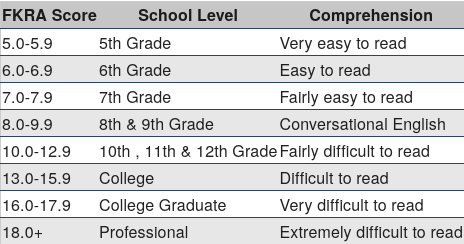

In [11]:
r = Readability(make_policy_files()[23].read())
fk = r.flesch_kincaid()
print(fk.score)
print(fk.grade_level) ## Higher is more complex

11.675919793850593
12


In [45]:
# db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

### 2.3 Wordcounts

it
427 total policies
Beware different scales!


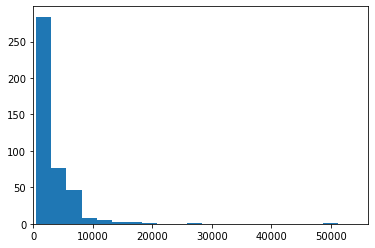

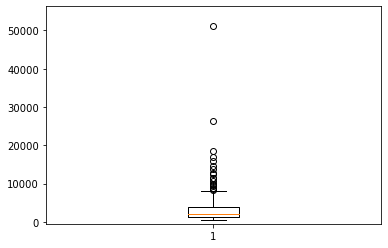

en
30 total policies
Beware different scales!


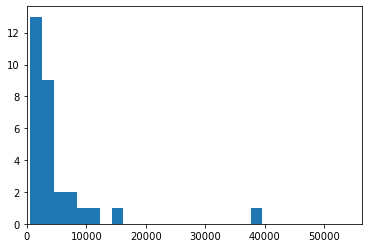

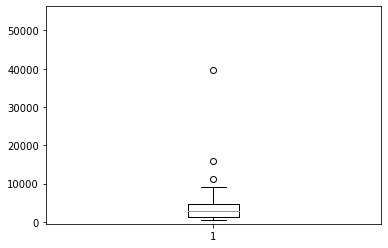

pl
1 total policies
Sample size for pl too small
de
1 total policies
Sample size for de too small


In [28]:
# Simple analysis i.e. wordcount

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

highest_wordcount = 0
for file in policy_files:
    file_wordcount = len(file.read().split())
    if file_wordcount > highest_wordcount:
        highest_wordcount = file_wordcount

    
for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)
    total_policies_current_language = len(policy_files)
    print(str(total_policies_current_language) + " total policies")
    if total_policies_current_language < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue
    
    wordcounts = []
    for file in policy_files:
        wordcounts.append(len(file.read().split()))

#     plt.ylim(0, 15)

#     plt.ylim(0, 300) # !!!
    print("Beware different scales!")

    plt.xlim(0, highest_wordcount * 1.1)
    plt.hist(wordcounts, 20)
    plt.show()
    
    plt.ylim(-(highest_wordcount / 100), highest_wordcount * 1.1)
    plt.boxplot(wordcounts)
    plt.show()

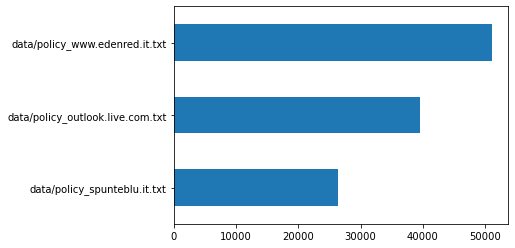

In [29]:
# Top 3 longest policies by wordcount overall

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

wc_dict = {}

for file in policy_files:
    wc_dict[file.name] = len(file.read().split())
    
wc_s = pd.Series(wc_dict).sort_values(ascending=True)
wc_s[len(wc_s) - 3:].plot.barh()
plt.show()

In [30]:
wc_s[len(wc_s) - 3:]

data/policy_spunteblu.it.txt        26444
data/policy_outlook.live.com.txt    39531
data/policy_www.edenred.it.txt      51160
dtype: int64

### 2.4 Wordclouds

it


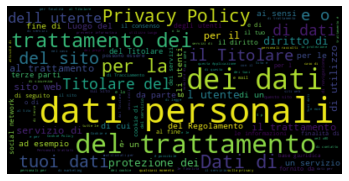

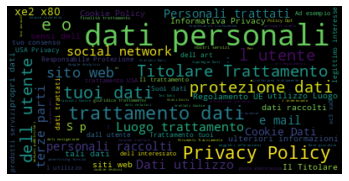

en


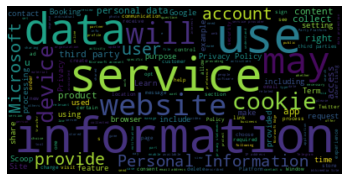

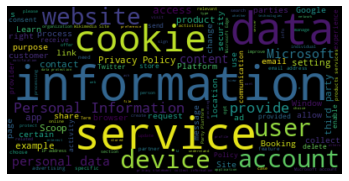

pl
Sample size for pl too small
de
Sample size for de too small


In [33]:
# Some fun wordclouds :)
# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))
    

for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)  
    
    if len(policy_files) < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue
    
    if language == "it":
        stoplist_lang = "Italian"
    elif language == "en":
        stoplist_lang = "English"
    else:
        print("Not english or italian")
        continue

    all_policy_text = ""
    for file in policy_files:
        all_policy_text += file.read()

    wordcloud = WordCloud().generate(all_policy_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    # Unsurprisingly you have to filter out heaps of words...
#     policy_files = []
#     for filename in policy_file_names:
#         policy_files.append(open(DATADIR + filename))
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))

    all_policy_text_filtered = ""
    for file in policy_files:
        for word in file.read().split():
            if word not in (justext.get_stoplist(stoplist_lang)): # Those built in stoplists are kinda awful
                all_policy_text_filtered += word + " "

    wordcloud = WordCloud().generate(all_policy_text_filtered)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### 2.5 Emotion analysis

In [11]:
# # Text2Emotion
# import text2emotion as t2e
# import emoji
# import nltk
# nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
# emotions_dict = {
#     "Angry" : 0,
#     "Fear" : 0,
#     "Happy" : 0,
#     "Sad" : 0,
#     "Surprise" : 0
# }

In [18]:
# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))

In [18]:
# for file in policy_files:
#     emotions = t2e.get_emotion(file.read())
#     top_emotion = max(emotions)
#     emotions_dict[top_emotion] = emotions_dict[top_emotion] + 1

# emotions_dict

In [19]:
# emotions_dict = {
#     "Angry" : 0,
#     "Fear" : 0,
#     "Happy" : 0,
#     "Sad" : 0,
#     "Surprise" : 0
# }

# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))

# for file in policy_files:
#     emotions = t2e.get_emotion(file.read())
#     for emotion in emotions:
#         emotions_dict[emotion] = emotions_dict[emotion] + emotions[emotion] # maybe normalize?

# emotions_dict

In [20]:
# for e in emotions_dict.keys():
#     emotions_dict[e] = round(emotions_dict[e] / len(policy_files), 3)

# emotions_dict

### 2.6 Text clustering

In [164]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

policy_texts = []

for file in policy_files:
    policy_texts.append(file.read())

df = pd.DataFrame(data = policy_texts, columns = ["Text"])
df

,Text
0,Privacy e termini Accedi Introduzione Norme su...
1,Skip to main content Privacy Policy Twitter Pr...
2,Privacy e termini Accedi Introduzione Norme su...
3,Passa a contenuti principali Microsoft Privacy...
4,"Privacy policy From Meta, a Wikimedia project ..."
...,...
275,Skip to main content An official website of th...
276,Privacy e termini Privacy e termini Accedi Int...
277,Skip to content MenuMenu Il seguente elemento ...
278,Skip to main content Sign In Try Now Teams For...


In [165]:
# There should be a separation based on the policy's language

vec = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3))
vec.fit(df.Text.values)
features = vec.transform(df.Text.values)

In [166]:
clust = KMeans(init = "k-means++", n_clusters = 2, n_init = 10)

clust.fit(features)
yhat = clust.predict(features)
df['Cluster Labels'] = clust.labels_

# df.loc[df["Cluster Labels"] == 1]

In [167]:
df_similar = pd.DataFrame(df.loc[df["Cluster Labels"] == 1].values)
# df_similar

In [168]:
df_dissimilar = pd.DataFrame(df.loc[df["Cluster Labels"] == 0].values)
# df_dissimilar

In [169]:
langs = pd.Series(languages).unique()

for lang in langs:
    print(lang)

it
en
zh
qu
la
fr
pt


In [276]:
for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
    else:
        break
        
    print("Current language: " + lang)

#     texts_in_lang = {}

    df_texts_in_lang = pd.DataFrame(columns = ["Text"])
    
    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
#             texts_in_lang.append(file_text)
#             texts_in_lang[file.name] = file_text
#             print(df_texts_in_lang)
#             df_texts_in_lang = df_texts_in_lang.append([file.name, file_text])
            df_texts_in_lang.loc[file.name] = file_text
    
#     print(texts_in_lang)
    
#     df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Filename", "Text"])

    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))


    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
#         stop_words="english",
    )

    try:
        X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    except ValueError:
        continue
    
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()


    kmeans = KMeans(
        n_clusters=2,
        max_iter=100,
        n_init=1,
    )

    kmeans.fit(X_lsa)

    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(2):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

Current language: it
Cluster 0: youtube risultati gmail esaminare vai android play identificatori chrome inserzionisti 
Cluster 1: microsoft terzi piattaforma to mail social media business proprio and 
Current language: en
Cluster 0: amazon university gov statement microsoft resources wikimedia disney health copyright 
Cluster 1: california shield categories profile ccpa legitimate apps platform uk advertisements 


In [277]:
df_texts_in_lang

,Text
data/policy_twitter.com.txt,Skip to main content Privacy Policy Twitter Pr...
data/policy_www.wikipedia.org.txt,"Privacy policy From Meta, a Wikimedia project ..."
data/policy_outlook.live.com.txt,Skip to main content Microsoft Privacy Privacy...
data/policy_github.com.txt,Skip to main content GitHub Docs All products ...
data/policy_wordpress.org.txt,Skip to content Log In Register WordPress.org ...
...,...
data/policy_wpengine.com.txt,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,Skip to main content Navigation Top bar naviga...
data/policy_www.irs.gov.txt,Skip to main content An official website of th...
data/policy_www.oreilly.com.txt,Skip to main content Sign In Try Now Teams For...


In [278]:
# df_texts_in_lang["Text"].index[2]

#### DBSCAN

In [297]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
)


texts_in_lang = []

for file in make_policy_files():
    file_text = file.read()
#     file_lang = langid.classify(file_text)[0]
#     if file_lang == lang:
    texts_in_lang.append(file_text)

# df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Text"])

# --

X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)

X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

X = X_lsa

db = DBSCAN(eps=1, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
# db.labels_

In [315]:
db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                             "Text" : df_texts_in_lang.Text},
#                              "Filename" : df_texts_in_lang.index},
                     index = df_texts_in_lang.index)
db_df

,Cluster,Text
data/policy_twitter.com.txt,0,Skip to main content Privacy Policy Twitter Pr...
data/policy_www.wikipedia.org.txt,0,"Privacy policy From Meta, a Wikimedia project ..."
data/policy_outlook.live.com.txt,0,Skip to main content Microsoft Privacy Privacy...
data/policy_github.com.txt,-1,Skip to main content GitHub Docs All products ...
data/policy_wordpress.org.txt,0,Skip to content Log In Register WordPress.org ...
...,...,...
data/policy_wpengine.com.txt,-1,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,-1,Skip to main content Navigation Top bar naviga...
data/policy_www.irs.gov.txt,-1,Skip to main content An official website of th...
data/policy_www.oreilly.com.txt,0,Skip to main content Sign In Try Now Teams For...


In [319]:
db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

,Cluster,Text
data/policy_github.com.txt,-1,Skip to main content GitHub Docs All products ...
data/policy_www.apple.com.txt,-1,Global Nav Open MenuGlobal Nav Close Menu Appl...
data/policy_wordpress.com.txt,-1,Automattic Home About Us News Work With Us Pri...
data/policy_bitly.com.txt,-1,Skip Navigation Get the tools to grow with Sta...
data/policy_www.nih.gov.txt,-1,Skip to main content An official website of th...
...,...,...
data/policy_www.ea.com.txt,-1,Electronic Arts Home\nFeatured GamesAll GamesC...
data/policy_www.newyorker.com.txt,-1,Skip to main content About Brands Stores Comme...
data/policy_wpengine.com.txt,-1,Skip to content WP Engine Products Resources W...
data/policy_www.frontiersin.org.txt,-1,Skip to main content Navigation Top bar naviga...


In [300]:
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# labels = [0, -1]
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k
    
#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()

#### 2.6.2 Finer Clustering

In [301]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(features)

def getind(c):
    return df[df.Text == c].index.tolist()

def gettext(i):
    return df[df.index == i].Text.tolist()

In [302]:
similar = list(enumerate(cosine_sim[0]))
# similar

In [303]:
# This one kinda does the same thing as the 2 clusters

sim_list = []
unsim_list = []
for m in similar:
    t = gettext(m[0])
    if m[1] > 0.15:
        sim_list.append(t)
    else:
        unsim_list.append(t)

In [304]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [305]:
# df_sim

In [306]:
# df_unsim

In [307]:
cosim = list(enumerate(cosine_sim))
cumulative_sim = []

for entry in cosim:
    cumulative_sim.append(0)

for entry in cosim:
    i = 0
    for sim_value in entry[1]:
        cumulative_sim[i] = cumulative_sim[i] + (sim_value / len(cosim)) # Normalization
        
        i = i + 1

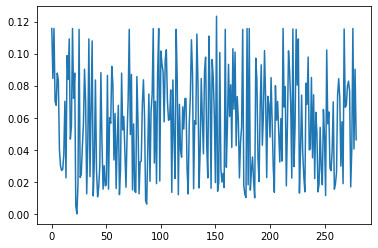

In [308]:
plt.plot(cumulative_sim)

In [309]:
sim_list = []
unsim_list = []

threshold = 0.085

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        sim_list.append(t)
    else:
        unsim_list.append(t)
    i = i + 1

In [310]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [311]:
# df_sim

In [312]:
# df_unsim

In [313]:
verysim_list = []

threshold = 0.185

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        verysim_list.append(t)
#     else:
#         unsim_list.append(t)
    i = i + 1

In [314]:
df_verysim = pd.DataFrame(verysim_list, columns = ["Text"])
df_verysim

,Text
